In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.ticker import MultipleLocator

import pandas as pd
import csv
import numpy as np
import os 
import re 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
train = pd.read_csv("data/3Classes_train.csv", sep="\t")
valid = pd.read_csv("data/3Classes_valid.csv", sep="\t")

y_train = train["Global classifier2"]
y_valid = valid["Global classifier2"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
valid.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh
0,Q96MN5,Mostly Organellar,MDKFVIRTPRIQNSPQKKDSGGKVYKQATIESLKRVVVVEDIKRWK...,208
1,P42575,Mostly Cytosolic,MAAPSAGSWSTFQHKELMAADRGRRILGVCGMHPHHQETLKKNRVV...,452
2,Q9NZP8,Mostly Organellar,MPGPRVWGKYLWRSPHSKGCPGAMWWLLLWGVLQACPTRGSVLLAQ...,487
3,Q96K80,Mostly Nuclear,MPDRDSYANGTGSSGGGPGGGGSEEASGAGVGSGGASSDAICRDFL...,434
4,Q86TA1,Mostly Cytosolic,MSIALKQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKA...,216


In [4]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'test sequences')

4015 train sequences
709 test sequences


In [5]:
max_len = len(max(x_train, key=len))
print(max_len)

1500


In [6]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [7]:
cat = ['Mostly Cytosolic', 'Mostly Nuclear', 'Mostly Organellar']

tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [8]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [8]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [9]:
# Function to convert sequences to array of indices. I will that that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [10]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [11]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (4015, 1500)
x_valid shape: (709, 1500)


In [12]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [13]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

# First Model

A very simple implementation based on: 

https://www.youtube.com/watch?v=oaV_Fv5DwUM 

https://github.com/keras-team/keras/issues/4962 

In [14]:
max_features = tot_aa +1
embedding_size = 80
units = 128

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(
        input_dim=max_features,
        output_dim=embedding_size,
        input_length=max_len,
        name = 'embedding_layer',
        trainable=True,
        mask_zero=False
    )(_input)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(embedded)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(3, activation='softmax')(sent_representation)

Instructions for updating:
Colocations handled automatically by placer.


In [61]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models_attention/1/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                           verbose=1, save_best_only=False)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=64, epochs=40,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 4015 samples, validate on 709 samples
Epoch 1/40
4015/4015 [==============================] - 366s 91ms/step - loss: 1.0147 - accuracy: 0.4722 - val_loss: 0.9807 - val_accuracy: 0.4824

Epoch 00001: saving model to models_attention/1/weights.01-0.98.hdf5
Epoch 2/40
4015/4015 [==============================] - 355s 88ms/step - loss: 0.9389 - accuracy: 0.5123 - val_loss: 0.9301 - val_accuracy: 0.5402

Epoch 00002: saving model to models_attention/1/weights.02-0.93.hdf5
Epoch 3/40
4015/4015 [==============================] - 339s 85ms/step - loss: 0.9370 - accuracy: 0.5061 - val_loss: 0.9297 - val_accuracy: 0.5331

Epoch 00003: saving model to models_attention/1/weights.03-0.93.hdf5
Epoch 4/40
4015/4015 [==============================] - 343s 85ms/step - loss: 0.8979 - accuracy: 0.5365 - val_loss: 0.9373 - val_accuracy: 0.5176

Epoch 00004: saving model to models_attention/1/weights.04-0.94.hdf5
Epoch 5/40
4015/4015 [==============================] - 340s 85ms/step - loss: 0.9006

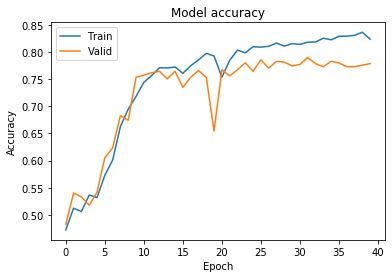

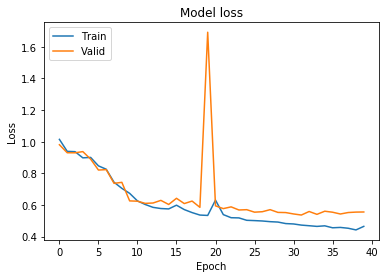

In [63]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [15]:
model = load_model('models_attention/1/weights.32-0.54.hdf5')

Instructions for updating:
Use tf.cast instead.


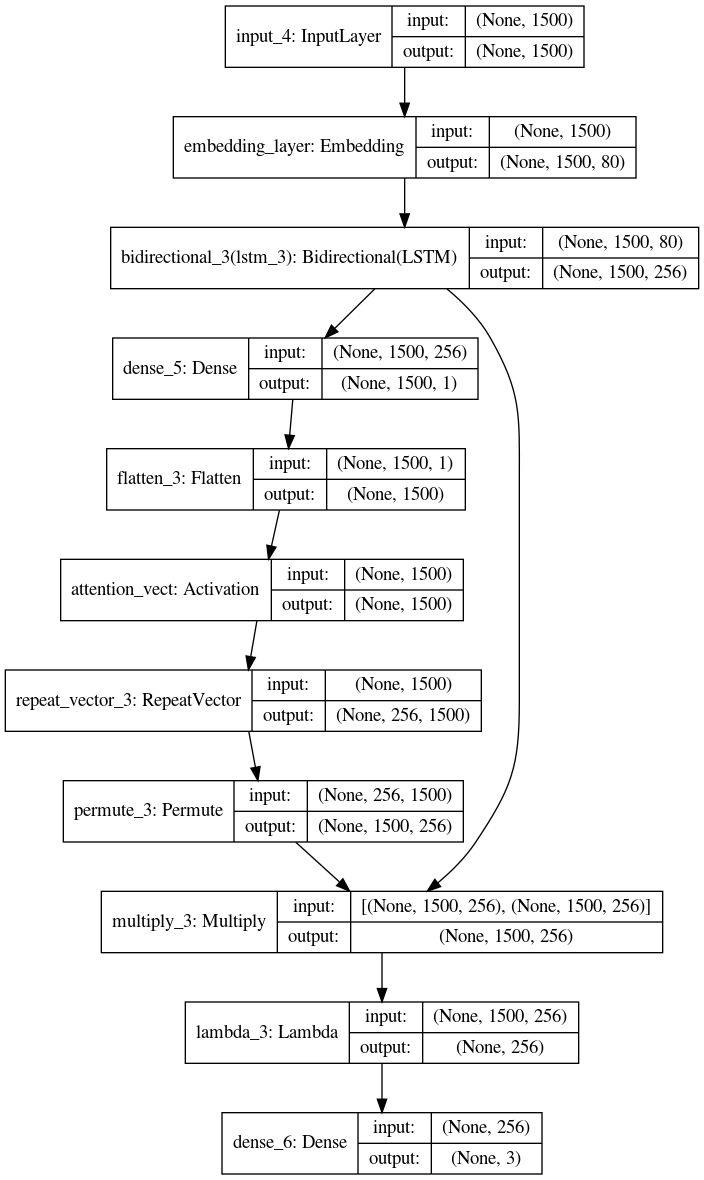

In [71]:
plot_model(model, to_file= 'models_attention/1/model_plot.png', show_shapes=True, show_layer_names=True)

In [72]:
model.evaluate(x_valid_pad, y_valid_OH)

709/709 [==============================] - 21s 30ms/step


[0.5361667240119956, 0.7898448705673218]

In [147]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_labels = indices_to_cat(y_pred_indices)

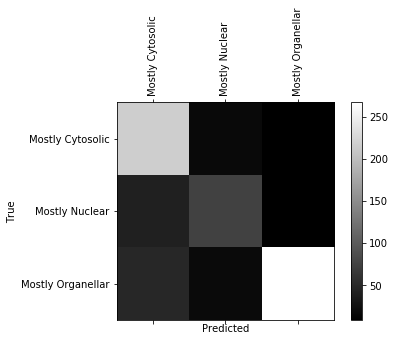

In [74]:
conf_mx = confusion_matrix(y_valid, y_pred_labels, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [75]:
conf_mx

array([[217,  19,   9],
       [ 42,  76,  10],
       [ 49,  20, 267]])

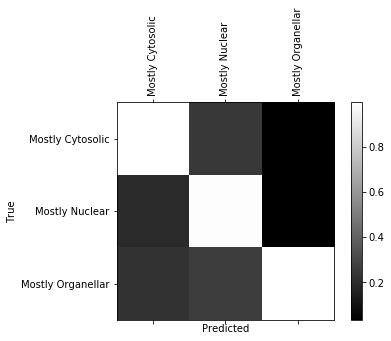

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [48]:
print(classification_report(y_valid, y_pred_labels))

                   precision    recall  f1-score   support

 Mostly Cytosolic       0.70      0.89      0.78       245
   Mostly Nuclear       0.66      0.59      0.63       128
Mostly Organellar       0.93      0.79      0.86       336

         accuracy                           0.79       709
        macro avg       0.77      0.76      0.76       709
     weighted avg       0.81      0.79      0.79       709



## Plot of the Embedding Layer

In [39]:
embedding = model.get_layer('embedding_layer').get_weights()
embedding = embedding[0]
embedding.shape

(23, 80)

In [40]:
# PCA plots of Embedding 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)

original shape:    (23, 80)
transformed shape: (23, 2)


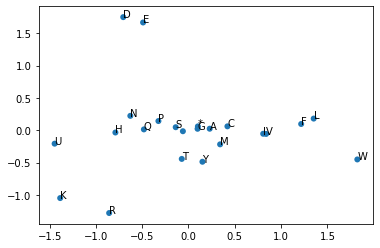

In [41]:
fig, ax = plt.subplots()
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], edgecolor='none')
aaL = list(aa)
for i in range(len(aaL)):
    ax.annotate(aaL[i], (embedding_pca[:, 0][i], embedding_pca[:, 1][i]))
    
plt.show()

## Plot the attention layer

I need some serious work on that one 

In [17]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('attention_vect').output])
outputs = model.predict(x_valid_pad)
model_outputs = outputs[0]
attention_outputs = outputs[1]

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Attention Distribution')

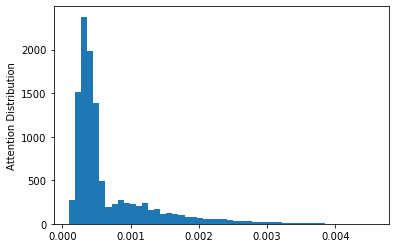

In [149]:
attention_distrib = np.concatenate( attention_outputs, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

In [150]:
# Normalize attention values 
norm_attention = []
for seq in attention_outputs:
    norm_attention.append(seq / np.linalg.norm(seq))

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Attention Distribution')

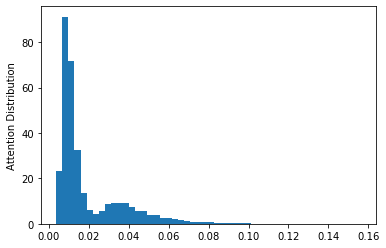

In [151]:
attention_distrib = np.concatenate( norm_attention, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

### Check attention for a single protein sequence

In [152]:
def indices_to_seq(X):
    seq = ''
    for i in range(len(X)):
        seq += int_to_aa[X[i]] 
    return seq

In [186]:
# I don't fully understand that code
# the color_charvals function doesn't work that well because my vector is big
# and the values are very small, I need a better function

class CharVal(object):
    def __init__(self, char, val):
        self.char = char
        self.val = val

    def __str__(self):
        return self.char

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def color_charvals(s):
    r = 0
    if s.val < 0.07:
        r = 255
    elif s.val > 0.1:
        r = 0
    else:
        r = 255*(1 - (s.val-0.07)/0.03)
    r = int(r)
    color = rgb_to_hex((255, r, 255))
    return 'background-color: %s' % color
    
    #r = int(255/(s.val*10 +1))
    #color = rgb_to_hex((r, r, r))
    #return 'background-color: %s' % color

In [16]:
X = 3

attention_output = attention_outputs[X][-max_len:]
attention_seq = attention_output[1500-len(x_valid[X]):]
attention = normalize(attention_seq[:,np.newaxis], axis=0).ravel()

# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], attention)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

NameError: name 'attention_outputs' is not defined

In [194]:
print(y_valid[X])
print(valid['Lead Protein ID'][X])
print(y_pred_labels[X])

Mostly Cytosolic
Q86TA1
Mostly Cytosolic


## Select the 'nb_max' maximum attention weights values position through all proteins from the valid dataset and Visualisation

Then, Compare motifs identified to this site: http://elm.eu.org/combined_search?query=NLS

In [155]:
# Number of highest values to select
nb_max = 50
max_att_indexes = []
for seq in norm_attention:
    max_att_indexes.append(np.sort(np.argpartition(seq, -nb_max)[-nb_max:]))
max_att_nopad = []    
for x in range(len(x_valid)):
    max_att_nopad.append(max_att_indexes[x]-(1500-len(x_valid[x])))

In [157]:
X = 1

def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255,255 , r))
    return 'background-color: %s' % color

max_ind = max_att_nopad[X]
max_vect = np.zeros(len(x_valid[X]))
for val in max_ind:
    max_vect[val] = 1
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], max_vect)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451
0,M,A,A,P,S,A,G,S,W,S,T,F,Q,H,K,E,L,M,A,A,D,R,G,R,R,I,L,G,V,C,G,M,H,P,H,H,Q,E,T,L,K,K,N,R,V,V,L,A,K,Q,L,L,L,S,E,L,L,E,H,L,L,E,K,D,I,I,T,L,E,M,R,E,L,I,Q,A,K,V,G,S,F,S,Q,N,V,E,L,L,N,L,L,P,K,R,G,P,Q,A,F,D,A,F,C,E,A,L,R,E,T,K,Q,G,H,L,E,D,M,L,L,T,T,L,S,G,L,Q,H,V,L,P,P,L,S,C,D,Y,D,L,S,L,P,F,P,V,C,E,S,C,P,L,Y,K,K,L,R,L,S,T,D,T,V,E,H,S,L,D,N,K,D,G,P,V,C,L,Q,V,K,P,C,T,P,E,F,Y,Q,T,H,F,Q,L,A,Y,R,L,Q,S,R,P,R,G,L,A,L,V,L,S,N,V,H,F,T,G,E,K,E,L,E,F,R,S,G,G,D,V,D,H,S,T,L,V,T,L,F,K,L,L,G,Y,D,V,H,V,L,C,D,Q,T,A,Q,E,M,Q,E,K,L,Q,N,F,A,Q,L,P,A,H,R,V,T,D,S,C,I,V,A,L,L,S,H,G,V,E,G,A,I,Y,G,V,D,G,K,L,L,Q,L,Q,E,V,F,Q,L,F,D,N,A,N,C,P,S,L,Q,N,K,P,K,M,F,F,I,Q,A,C,R,G,D,E,T,D,R,G,V,D,Q,Q,D,G,K,N,H,A,G,S,P,G,C,E,E,S,D,A,G,K,E,K,L,P,K,M,R,L,P,T,R,S,D,M,I,C,G,Y,A,C,L,K,G,T,A,A,M,R,N,T,K,R,G,S,W,Y,I,E,A,L,A,Q,V,F,S,E,R,A,C,D,M,H,V,A,D,M,L,V,K,V,N,A,L,I,K,D,R,E,G,Y,A,P,G,T,E,F,H,R,C,K,E,M,S,E,Y,C,S,T,L,C,R,H,L,Y,L,F,P,G,H,P,P,T


So... Now I need to look for NLS in valid set and check whether attention catch all of them by comparing sequence indices from max attention

## Get regions deemed important by the attention layer  into the Dataframe

In [55]:
motifs_loc = []
motifs = []
stop = 0
for l in max_att_nopad:
    start = l[0]
    for i in range(1,len(l)):
        if l[i-1] + 3 >= l[i]:
            stop = l[i]
        else:
            if start < stop:
                motifs.append((start, stop))
            start = l[i]
    if start < stop:
        motifs.append((start, stop))
    motifs_loc.append(motifs)
    motifs = []


In [88]:
motifs_aa = []
motifs = []
for i in range(len(motifs_loc)):
    seq = x_valid[i]
    m = motifs_loc[i]
    for tup in m:
        motifs.append(seq[tup[0]:tup[1]+1])
    motifs_aa.append(motifs)
    motifs = []

In [89]:
valid["Model Prediction"] = y_pred_labels

In [90]:
valid["Motifs"] = motifs_aa
valid["Motifs Localization"] = motifs_loc

In [91]:
valid['Motifs']

0      [QNSPQKKDSGG, ELPD, ELKKKIPSREVLKSTRIGH, DSE, ...
1      [ELMAADRGRRILGVCGMHPHHQETLKKNRVVLAKQLLLSELLEHL...
2      [RVWGKYLWRSPHSKGCPGAMWWLLLWGVL, LLAQE, EN, DRQ...
3      [RNVCKRGKRCRYRHPDMSE, NEFIFCHDFQNKE, KEDEDGY, ...
4      [KQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKAAVQL...
                             ...                        
704    [LGGGGEAR, LGS, EDCDCAQDENCK, DRDSRCNL, CDGLE,...
705    [AKDGLQQSKCPDTTP, DAE, PEE, LAE, LSE, EE, EE, ...
706    [IDAD, EPD, ITPL, HSEHVGLDNDLREKYMQE, QD, LRCE...
707    [CT, VMD, ALNGFGGMC, IQ, RAFAFT, LVGFGVTCLIPNL...
708    [VYMIRVYLLQGWYIVTYALGIYHLNLFIAFLSPKVD, ED, VCT...
Name: Motifs, Length: 709, dtype: object

### Description of ELM Regex
http://elm.eu.org/infos/help.html

Regular expression usefull links:
https://www.debuggex.com/cheatsheet/regex/python
https://regex101.com/#python

In [69]:
NLS_regex = ['[KR][KR].{7,15}[^DE]((K[RK])|(RK))(([^DE][KR])|([KR][^DE]))[^DE]',
             '[^DE]((K[RK])|(RK))[KRP][KR][^DE]',
             '[^DE]((K[RK])|(RK))(([^DE][KR])|([KR][^DE]))(([PKR])|([^DE][DE]))',
             '(([PKR].{0,1}[^DE])|([PKR]))((K[RK])|(RK))(([^DE][KR])|([KR][^DE]))[^DE]']

NES_regex = ['([DEQ].{0,1}[LIM].{2,3}[LIVMF][^P]{2,3}[LMVF].[LMIV].{0,3}[DE])|([DE].{0,1}[LIM].{2,3}[LIVMF][^P]{2,3}[LMVF].[LMIV].{0,3}[DEQ])']

In [105]:
NLS_valid = []
NLS_nb = 0 # count seq with NLS
for seq in x_valid:
    NLS = []
    for motifs in NLS_regex:
        match = re.finditer(motifs, seq)
        if match:
            for m in match:
                NLS.append((m.start(), m.end()))
    if NLS != []:
        NLS.sort(key=lambda tup: tup[1])
        NLS_nb +=1 
    NLS_valid.append(NLS)
                

In [108]:
print(str(NLS_nb/len(x_valid)*100) + '% of proteins in valid set have at least one NLS motifs')

41.18476727785614% of proteins in valid set have at least one NLS motifs


In [96]:
valid["NLS positions"] = NLS_valid

In [102]:
Nuclear = valid.loc[valid['Global classifier2'] == 'Mostly Nuclear']
Nuclear.loc[:, 'Model Prediction':'NLS positions']

,Model Prediction,Motifs,Motifs Localization,NLS positions
3,Mostly Cytosolic,"[RNVCKRGKRCRYRHPDMSE, NEFIFCHDFQNKE, KEDEDGY, ...","[(46, 64), (73, 85), (98, 104), (187, 196), (2...","[(49, 55), (50, 58), (206, 212), (204, 212)]"
15,Mostly Cytosolic,[DFHRIQEKTGNDWVPVTIIDVRGHSYLQENKIKTTDLHRPLHDEM...,"[(41, 420), (91, 420), (127, 133), (137, 151),...","[(20, 28)]"
16,Mostly Nuclear,[DRPGEGSYNRYYSHVDYRDYDEGRSFSHDRRSGPPHRGDESGYRW...,"[(41, 561), (45, 561), (56, 61), (79, 80), (88...","[(387, 393), (388, 394), (387, 395)]"
18,Mostly Nuclear,"[PKTVKMPKPSKIPKPPKPPKPPRPPKTLKLKDGGKK, DD, KKK...","[(493, 528), (899, 900), (950, 956), (1050, 10...","[(61, 67), (62, 68), (488, 494), (486, 494), (..."
25,Mostly Organellar,"[QQPR, EKP, SGGAEDD, DLPQ, DN, DE, RENPHK, EMH...","[(8, 11), (23, 25), (43, 49), (77, 80), (112, ...","[(26, 32), (24, 32), (27, 33)]"
...,...,...,...,...
683,Mostly Cytosolic,"[EE, VD, GTCFGKFTKTHKFRLHVTALDYLAPYAK, IKPGAEQ...","[(5, 6), (27, 28), (66, 93), (98, 104), (142, ...",[]
684,Mostly Nuclear,[DLTGDGDGEDGDGSDTPVMPKLFRETRTRSESPAVRTRNNNSVSS...,"[(68, 176), (72, 77), (111, 124), (131, 134), ...","[(379, 401), (393, 401)]"
685,Mostly Cytosolic,"[CGDKASGR, YSCRGSKDCIINKHHRNRCQYCRLQRCIAFGMKQD...","[(115, 122), (146, 180), (408, 413), (438, 443)]",[]
686,Mostly Nuclear,"[KDKRISK, ASKIK, DDED, KKSNKKTNEHGMKTFRKVKDSSS...","[(20, 26), (35, 39), (164, 167), (383, 408), (...","[(139, 145), (140, 146), (259, 278), (272, 278..."


# Error Analysis

In [109]:
# THIS CODE OUTPUT THE INDICES FOR CORRECT AND INCORRECT EXEMPLES.
corrects = []
falses = []
for x in range(len(y_valid)):
    if y_valid_indices[x] == y_pred_indices[x]:
        corrects.append(x)
    else:
        falses.append(x)

In [110]:
print('There is ' + str(len(corrects)) + ' correctly classified exemples')
print('There is ' + str(len(falses)) + ' incorrectly classified exemples')
print('So the accuracy is: ' + str(len(corrects)/len(x_valid)*100))

There is 560 correctly classified exemples
There is 149 incorrectly classified exemples
So the accuracy is: 78.98448519040903


In [111]:
corrects_df = valid[valid.index.isin(corrects)]
falses_df = valid[valid.index.isin(falses)]

In [112]:
corrects_df.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh,Model Prediction,Motifs,Motifs Localization,NLS positions
1,P42575,Mostly Cytosolic,MAAPSAGSWSTFQHKELMAADRGRRILGVCGMHPHHQETLKKNRVV...,452,Mostly Cytosolic,[ELMAADRGRRILGVCGMHPHHQETLKKNRVVLAKQLLLSELLEHL...,"[(15, 207), (20, 207), (37, 207), (51, 63), (9...","[(23, 45), (148, 156)]"
2,Q9NZP8,Mostly Organellar,MPGPRVWGKYLWRSPHSKGCPGAMWWLLLWGVLQACPTRGSVLLAQ...,487,Mostly Organellar,"[RVWGKYLWRSPHSKGCPGAMWWLLLWGVL, LLAQE, EN, DRQ...","[(4, 32), (42, 46), (145, 146), (217, 223), (4...","[(406, 412)]"
4,Q86TA1,Mostly Cytosolic,MSIALKQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKA...,216,Mostly Cytosolic,[KQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKAAVQL...,"[(5, 271), (9, 17), (25, 28), (35, 37), (50, 5...",[]
5,Q15084,Mostly Organellar,MALLVLGLVSCTFFLAVNGLYSSSDDVIELTPSNFNREVIQSDSLW...,440,Mostly Organellar,"[VLGLVSCTFFLAVNGLYSSSDDVIE, WCGH, PED, GEAIVD,...","[(4, 28), (53, 56), (110, 112), (119, 124), (1...","[(325, 332)]"
6,Q9BV94,Mostly Organellar,MPFRLLIPLGLLCALLPQHHGAPGPDGSAPDPAHYRERVKAMFYHA...,578,Mostly Organellar,"[LGLLCALL, LIDALD, DSVD, KRSR, VSSGPWEPP, SPEN...","[(8, 15), (77, 82), (102, 105), (508, 511), (5...",[]


In [169]:
falses_df.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh,Model Prediction
0,Q96MN5,Mostly Organellar,MDKFVIRTPRIQNSPQKKDSGGKVYKQATIESLKRVVVVEDIKRWK...,208,Mostly Nuclear
3,Q96K80,Mostly Nuclear,MPDRDSYANGTGSSGGGPGGGGSEEASGAGVGSGGASSDAICRDFL...,434,Mostly Cytosolic
15,Q92802,Mostly Nuclear,MSYGEIEGKFLGPREEVTSEPRCKKLKSTTESYVFHNHSNADFHRI...,583,Mostly Cytosolic
17,Q6ICC9,Mostly Cytosolic,MVQPQTSKAESPALAASPNAQMDDVIDTLTSLRLTNSALRREASTL...,239,Mostly Nuclear
19,Q6IQ19,Mostly Organellar,MSPGSGVKSEYMKRYQEPRWEEYGPCYRELLHYRLGRRLLEQAHAP...,270,Mostly Nuclear


## Checking the model on the test set

In [124]:
test = pd.read_csv("data/3Classes_test.csv", sep="\t")
y_test = test["Global classifier2"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

In [84]:
model = load_model('models_attention/1/weights.32-0.54.hdf5')
score = model.evaluate(x_test_pad, y_test_OH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

834/834 [==============================] - 29s 35ms/step
Test loss: 0.49091512497237544
Test accuracy: 0.8033573031425476


## Model 2: CNN LSTM with attention 

In [114]:
max_features = tot_aa + 1
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 20
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(3, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

In [116]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models_attention/2/CNN_model_weights', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 4015 samples, validate on 709 samples
Epoch 1/60
4015/4015 [==============================] - 373s 93ms/step - loss: 0.9891 - accuracy: 0.4879 - val_loss: 0.9244 - val_accuracy: 0.5346

Epoch 00001: val_loss improved from inf to 0.92439, saving model to models_attention/2/CNN_model_weights
Epoch 2/60
4015/4015 [==============================] - 321s 80ms/step - loss: 0.8760 - accuracy: 0.5482 - val_loss: 1.1152 - val_accuracy: 0.5134

Epoch 00002: val_loss did not improve from 0.92439
Epoch 3/60
4015/4015 [==============================] - 318s 79ms/step - loss: 0.7899 - accuracy: 0.6331 - val_loss: 0.6896 - val_accuracy: 0.7391

Epoch 00003: val_loss improved from 0.92439 to 0.68956, saving model to models_attention/2/CNN_model_weights
Epoch 4/60
4015/4015 [==============================] - 317s 79ms/step - loss: 0.6600 - accuracy: 0.7240 - val_loss: 0.6340 - val_accuracy: 0.7532

Epoch 00004: val_loss improved from 0.68956 to 0.63396, saving model to models_attention/2/CNN_m

4015/4015 [==============================] - 315s 78ms/step - loss: 0.3312 - accuracy: 0.8812 - val_loss: 0.5906 - val_accuracy: 0.7997

Epoch 00039: val_loss did not improve from 0.54545
Epoch 40/60
4015/4015 [==============================] - 314s 78ms/step - loss: 0.3276 - accuracy: 0.8894 - val_loss: 0.5855 - val_accuracy: 0.7884

Epoch 00040: val_loss did not improve from 0.54545
Epoch 41/60
4015/4015 [==============================] - 322s 80ms/step - loss: 0.3146 - accuracy: 0.8892 - val_loss: 0.6100 - val_accuracy: 0.7927

Epoch 00041: val_loss did not improve from 0.54545
Epoch 42/60
4015/4015 [==============================] - 314s 78ms/step - loss: 0.3051 - accuracy: 0.8872 - val_loss: 0.5959 - val_accuracy: 0.7927

Epoch 00042: val_loss did not improve from 0.54545
Epoch 43/60
4015/4015 [==============================] - 316s 79ms/step - loss: 0.3112 - accuracy: 0.8854 - val_loss: 0.5992 - val_accuracy: 0.8054

Epoch 00043: val_loss did not improve from 0.54545
Epoch 44/60


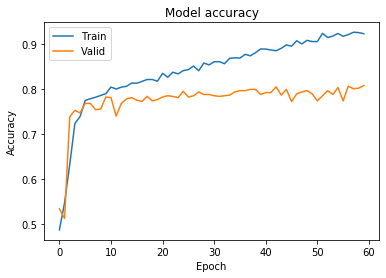

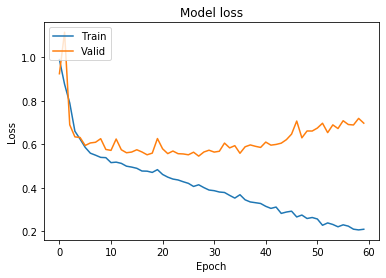

In [117]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

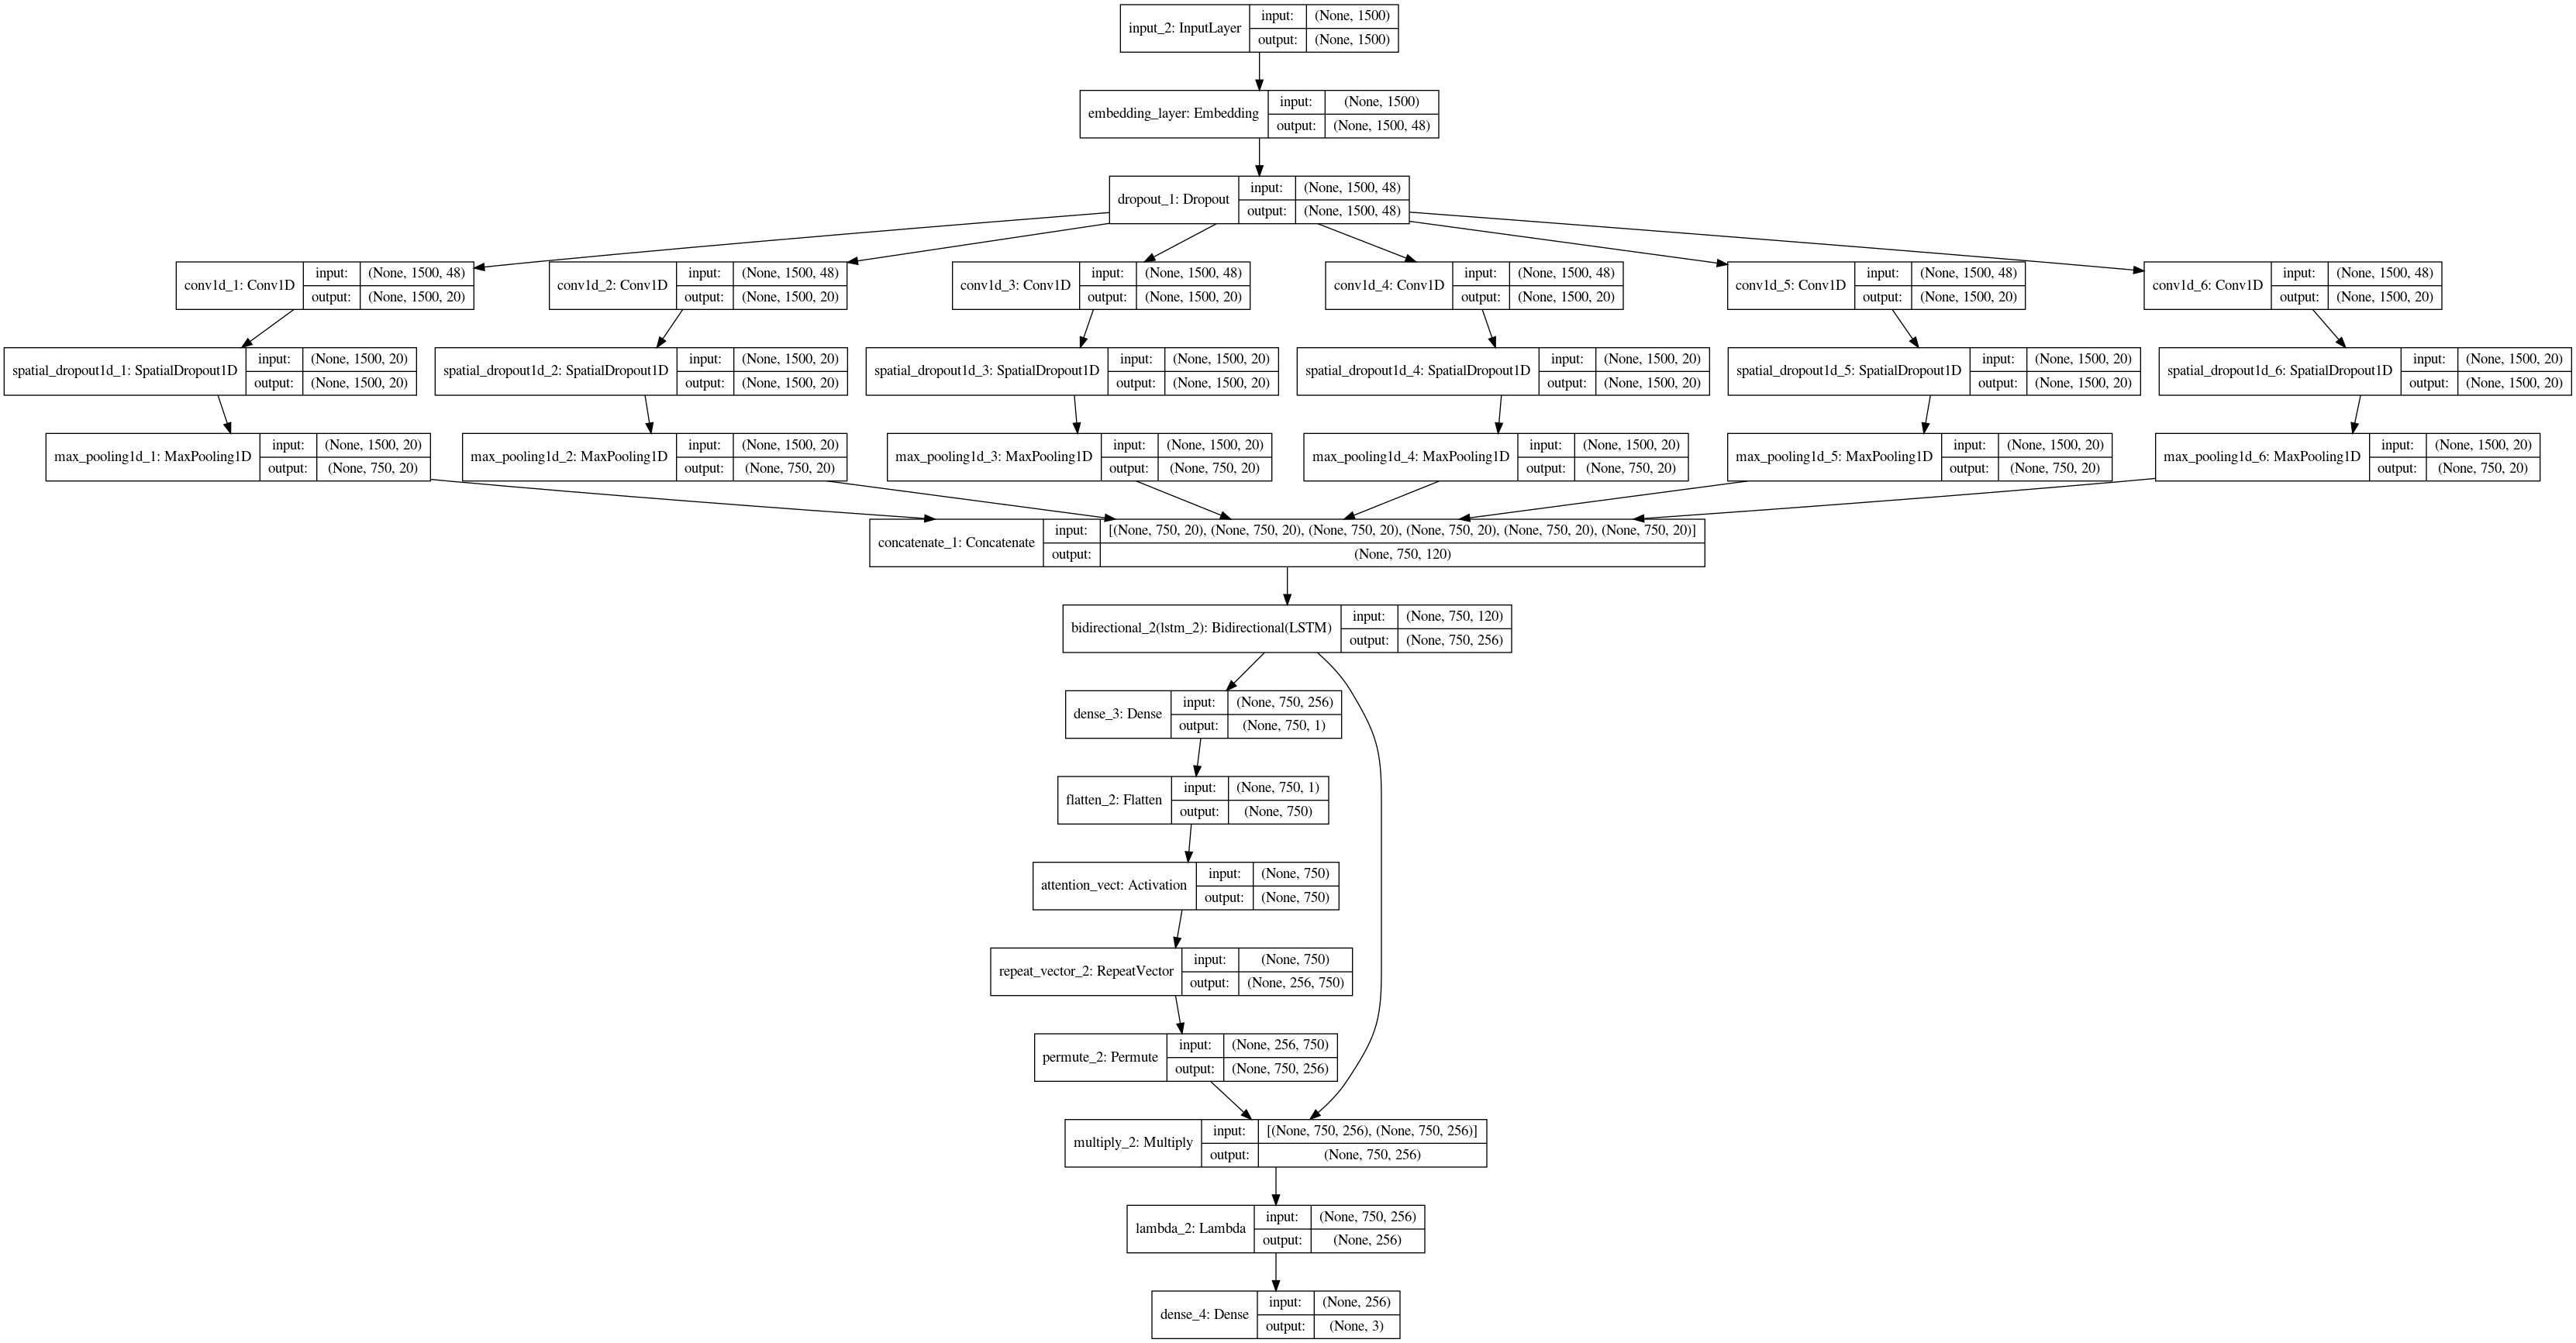

In [122]:
plot_model(model, to_file='models_attention/2/CNN_model_plot.png', show_shapes=True, show_layer_names=True)

In [168]:
model2 = load_model('models_attention/2/CNN_model_weights.hdf5')

In [160]:
model2.evaluate(x_valid_pad, y_valid_OH, verbose=0)

[0.5454519885803648, 0.794076144695282]

In [161]:
y_pred2 = model2.predict(x_valid_pad)
y_pred_indices2 = OH_to_label_indices(y_pred2)
y_pred_labels2 = indices_to_cat(y_pred_indices2)

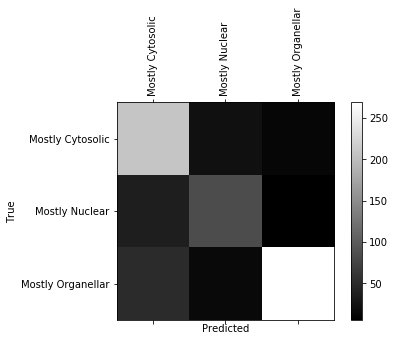

In [162]:
conf_mx2 = confusion_matrix(y_valid, y_pred_labels2, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx2, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Attention Analysis 

In [169]:
model2 = Model(inputs=model2.input,
              outputs=[model2.output, model2.get_layer('attention_vect').output])
outputs2 = model2.predict(x_valid_pad)
model_outputs2 = outputs[0]
attention_outputs2 = outputs[1]
attention_outputs2.shape

(709, 750)

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution')

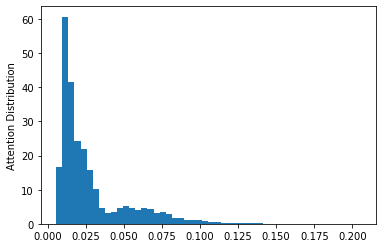

In [164]:
# Normalize attention values 
norm_attention2 = []
for seq in attention_outputs2:
    norm_attention2.append(seq / np.linalg.norm(seq))
    
attention_distrib2 = np.concatenate( norm_attention2, axis=0 )
plt.hist(attention_distrib2, normed=True, bins=50)
plt.ylabel('Attention Distribution')

In [ ]:
# So... it has nothing to do with the type of model.. since this is the same I used for 8 compartment analysis

In [165]:
# pool_size = 2
Attention_1500_2 = []
A = []
for x in norm_attention2:
    for i in range(len(x)):
        A.append(x[i])
        A.append(x[i])
    Attention_1500_2.append(np.array(A))
    A = []
    
# Number of highest values to select
nb_max = 50
max_att_indexes2 = []
for seq in Attention_1500_2:
    max_att_indexes2.append(np.sort(np.argpartition(seq, -nb_max)[-nb_max:]))
max_att_nopad2 = []    
for x in range(len(x_valid)):
    max_att_nopad2.append(max_att_indexes[x]-(1500-len(x_valid[x])))

In [166]:
X = 1

def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255,255 , r))
    return 'background-color: %s' % color

max_ind = max_att_nopad2[X]
max_vect = np.zeros(len(x_valid[X]))
for val in max_ind:
    max_vect[val] = 1
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], max_vect)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451
0,M,A,A,P,S,A,G,S,W,S,T,F,Q,H,K,E,L,M,A,A,D,R,G,R,R,I,L,G,V,C,G,M,H,P,H,H,Q,E,T,L,K,K,N,R,V,V,L,A,K,Q,L,L,L,S,E,L,L,E,H,L,L,E,K,D,I,I,T,L,E,M,R,E,L,I,Q,A,K,V,G,S,F,S,Q,N,V,E,L,L,N,L,L,P,K,R,G,P,Q,A,F,D,A,F,C,E,A,L,R,E,T,K,Q,G,H,L,E,D,M,L,L,T,T,L,S,G,L,Q,H,V,L,P,P,L,S,C,D,Y,D,L,S,L,P,F,P,V,C,E,S,C,P,L,Y,K,K,L,R,L,S,T,D,T,V,E,H,S,L,D,N,K,D,G,P,V,C,L,Q,V,K,P,C,T,P,E,F,Y,Q,T,H,F,Q,L,A,Y,R,L,Q,S,R,P,R,G,L,A,L,V,L,S,N,V,H,F,T,G,E,K,E,L,E,F,R,S,G,G,D,V,D,H,S,T,L,V,T,L,F,K,L,L,G,Y,D,V,H,V,L,C,D,Q,T,A,Q,E,M,Q,E,K,L,Q,N,F,A,Q,L,P,A,H,R,V,T,D,S,C,I,V,A,L,L,S,H,G,V,E,G,A,I,Y,G,V,D,G,K,L,L,Q,L,Q,E,V,F,Q,L,F,D,N,A,N,C,P,S,L,Q,N,K,P,K,M,F,F,I,Q,A,C,R,G,D,E,T,D,R,G,V,D,Q,Q,D,G,K,N,H,A,G,S,P,G,C,E,E,S,D,A,G,K,E,K,L,P,K,M,R,L,P,T,R,S,D,M,I,C,G,Y,A,C,L,K,G,T,A,A,M,R,N,T,K,R,G,S,W,Y,I,E,A,L,A,Q,V,F,S,E,R,A,C,D,M,H,V,A,D,M,L,V,K,V,N,A,L,I,K,D,R,E,G,Y,A,P,G,T,E,F,H,R,C,K,E,M,S,E,Y,C,S,T,L,C,R,H,L,Y,L,F,P,G,H,P,P,T


In [ ]:
# Ok so with these model the accuracy is better but it didn't pick up the same regions at all (and for both X=3 is wrong)
# So maybe convolution or pool is not the best idea because I have not clue 

In [142]:
y_valid[1]

'Mostly Cytosolic'

In [143]:
y_pred_labels[1]

'Mostly Cytosolic'

### Test CNN model on test set

In [125]:
model.evaluate(x_test_pad, y_test_OH)

834/834 [==============================] - 23s 28ms/step


[0.4933147064859061, 0.8129496574401855]